# Comment expliquer les déserts médicaux?

## 1. Résumé

Nous utilisons et enrichissons des données issues du magazine _Marianne_ pour expliquer l'existence de déserts médicaux en France métropoloitaine. Dans [cette enquête d'octobre 2021](https://www.marianne.net/societe/sante/comment-marianne-a-enquete-sur-les-deserts-medicaux), les journalistes ont tenté de prendre un rendez-vous médical dans un grand nombre de villes de France chez différents spécialistes (généralistes, gynécologues, dentistes, ophtalmologues, pédiatres, dermatologues) et ont noté le temps d'attente pour obtenir un tel rendez-vous.

![](img/im1.jpg)

Nous transformons ces données (diffusées au format JPG) pour pouvoir les exploiter. Puis nous collectons des données susceptibles d'expliquer ce temps d'attente:

1. soit directement par l'attractivité de la ville pour les médecins (ex: météo)
2. soit indirectement via une patientèle plus nombreuse (ex: densité de population, personnes âgées)

La collecte des données occupe la section 2 de ce rapport et mobilise notamment la reconnaissance de caractère (OCR) et l'extraction de données de différents sites Internet (INSEEE, https://www.villesetvillagesouilfaitbonvivre.com/ et Wikipédia). Au final nous collectons les variables suivantes:

* densité
* pluviométrie
* ensoleillement
* température
* taux de plus de 60 ans
* revenu par unité de consommation médiane
* classement sur https://www.villesetvillagesouilfaitbonvivre.com/
* nombre de nuités en hôtel
* nombre de nuites en camping

Pour finir, à partir des **314 territoires étudiés par _Marianne_ nous obtenons un jeu de données de seulement 56 communes** avec toutes les variables collectées. (Notons que déjà dans l'article, certains temps d'attente sont manquants, sans doute pour cause d'absence du spécialiste en question. L'obtention d'un jeu de données plus étoffé est bien évidemment une piste de progression, cf. section 7.) Le détail est ci-dessous:

In [1]:
import pandas as pd

waiting = pd.read_csv("data/2-6-cancatenated-data.csv", index_col=0) # cf. section 2-5 for origin

# rate of NA values for each variable
print("Taux de valeur manquante pour les différentes variables :\n")
print(waiting.isna().sum() / waiting.shape[0])

Taux de valeur manquante pour les différentes variables :

City                            0.079618
Dentist                         0.098726
Dermatologist                   0.207006
GP                              0.101911
Gynécologist                    0.200637
Ophtalmologist                  0.200637
Pédiatrician                    0.404459
Rank                            0.079618
department                      0.079618
thousand_nights_in_hotels       0.079618
thousand_nights_in_campsites    0.095541
population                      0.000000
density                         0.000000
rate_60_and_over                0.006369
median_income                   0.003185
attractiveness_rank             0.079618
solar_exposure                  0.710191
precipitation                   0.480892
temperature                     0.522293
dtype: float64


In [2]:
print("Number of municipalities:", waiting.shape[0])
print("Number of complete ones:", waiting.dropna().shape[0])

Number of municipalities: 314
Number of complete ones: 56


Ensuite, lors d'une **exploration des données** (section 3), nous trouvons pas d'interdépendance entre les temps d'attente chez les différents spécialistes : ce ne sont pas les mêmes territoires qui manquent de pédiatres et ceux qui manquent de généralistes ou de dermatologues. Ces mêmes temps d'attente ne suivent pas non plus une distribution spatiale claire : des villes proches peuvent avoir des temps d'attente largement différents. Enfin, nous étudions la dépendance entre les temps d'attente et les variables explicatives que nous avons collectées.

Notre principal résultat (section 4) est reproduit ci-dessous. Il s'agit d'une part, de l'**importance de nos variables pour expliquer le temps d'attente chez un généraliste**. D'autre part d'une **carte du temps d'attente chez le généraliste résiduel**. Notons bien que cette analyse, très préliminaire, ne peut en aucun cas être interprétée de façon causale et une discussion approfondie du caractère exogène des variables explicatives sort largement du cadre de ce travail. Notons également que l'exemple du généraliste est pris pour ne pas surcharger l'analyse, mais que l'exercice pourrait tout à fait être répété pour les 5 autres spécialités.

<BarContainer object of 10 artists>

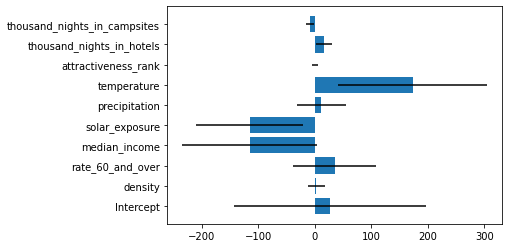

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as pp

variables = [
    'GP',
    "density", 'rate_60_and_over',  "median_income",
    'solar_exposure', 'precipitation', 'temperature',
    "attractiveness_rank",
    'thousand_nights_in_hotels', 'thousand_nights_in_campsites'
]

waiting_complete = waiting[variables].copy().dropna()

formula = str( variables[0] ) + "~" + "+".join(variables[1:])
# print(formula)

results = smf.ols( # cf. section 4-1 for discussion
    formula,
    data = waiting_complete
).fit()

waiting_complete['resid'] = results.resid
means = np.concatenate(( [1], waiting_complete[variables[1:]].mean()))
ci = results.conf_int()
relative_width = ci.max(axis=1)-ci.mean(axis=1)

# TODO: add confidence intervals
pp.barh(
    y=range(len(means)),
    xerr  = relative_width*means, # ci.mul(means, axis="rows").to_numpy().transpose(),
    width = results.params * means,
    tick_label = results.params.index
)

In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GP   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     2.259
Date:                Thu, 06 Jan 2022   Prob (F-statistic):             0.0288
Time:                        17:56:21   Log-Likelihood:                -376.01
No. Observations:                  75   AIC:                             772.0
Df Residuals:                      65   BIC:                             795.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       26.9996     85.051      0.317      0.752    -142.858     196.858
density                          0.0010      0.004      0.277      0.783      -0.006       0.008
rate_60_and_over                 1.2656      1.338      0.946      0.348      -1.406       3.937
median_income                   -0.0058      0.003     -1.929      0.058      -0.012       0.000
solar_exposure                  -0.0579      0.024     -2.445      0.017      -0.105      -0.011
precipitation                    0.0139      0.027      0.510      0.612      -0.041       0.068
temperature                     14.1896      5.408      2.624      0.011       3.388      24.991
attractiveness_rank             -0.0010      0.007     -0.145      0.885      -0.015       0.013
thousand_nights_in_hotels        0.0089      0.004      2.241      0.028       0.001       0.017
thousand_nights_in_campsites    -0.0056      0.002     -2.411      0.019      -0.010      -0.001
==============================================================================
Omnibus:                       25.888   Durbin-Watson:                   2.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.131
Skew:                           1.416   Prob(JB):                     3.18e-09
Kurtosis:                       5.121   Cond. No.                     3.83e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**L'interprétation de ces résultats est périlleuse.** Même la moyenne nationale de 27 jours d'attente n'est pas significative au seuil de 5%. Les seules variables qui semblent pouvoir s'interpréter sont la température (qui augmente le temps d'attente) et l'ensoleillement (qui le diminue) ainsi que les nuités en hôtels (augmente) et en camping (diminue). La densité de peuplement et le revenu médian, que nous anticipions être fortement prédictifs, ne ressortent pas. Ceci appelle à considérer avec précaution:

1. La qualité du relevé effectué par _Marianne_ (une seule période de l'année, selon une méthodologie seulement partiellement renseignée)
2. La sélectivité de notre méthode de traitement des données incomplètes (suppression pure et simple)

Maintenant, sous réserve que nous soyons en mesure d'améliorer ces premiers résultats d'analyse, nous pouvons également regarder si, une fois contrôlés par les variables explicatives, les temps d'attente résiduels présentent des motifs géographiques. Cela suggérerait en effet des phénomènes socio-spatiaux additionnels pouvant expliquer les déserts médicaux. À cette fin, **nous cartographions les résidus** sur une carte **interactive**, à l'aide de laquelle il est possible d'explorer les données :

In [132]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from math import sqrt
from matplotlib.colors import rgb2hex

# read shapefiles
communes = gpd.read_file("data/sp/communes/communes-20190101.json")
communes = communes.rename(columns={'nom': 'City'})

# bring back variables in the game
waiting_complete_2 = pd.merge(waiting, waiting_complete, how='right')
# merge 
waiting_complete_2 = pd.merge(communes, waiting_complete_2, how='inner', on='City')
# here we lose data from both datasets here, cf. section 7

# collect centroids of shapes
waiting_complete_2['lon'] = waiting_complete_2.geometry.centroid.x
waiting_complete_2['lat'] = waiting_complete_2.geometry.centroid.y

# color maps go from [0,1] to RGB space
# hence we normalise the residuals from 0 to 1
residuals = (waiting_complete_2['resid']-min(waiting_complete_2['resid']))
residuals = residuals/max(residuals)
residuals
# this operation does not necessary maps 0 to 0.5 as expected
# see section 7
colors = plt.cm.bwr(residuals)

# now let's draw the map
m = folium.Map(tiles='Stamen Toner')

# add circles one by one
for i in range(0,len(waiting_complete_2)):
    folium.Circle(
        [waiting_complete_2.iloc[i]['lat'], waiting_complete_2.iloc[i]['lon']],
        radius = 50*sqrt(waiting_complete_2.iloc[i]['population']),
        popup = str(waiting_complete_2.iloc[i]['City'])+"<br> Résidu: "+str(waiting_complete_2.iloc[i]['resid']),
        color = rgb2hex(colors[i]),
        weight = 3,
        fill_color = rgb2hex(colors[i]),
        fill = True,
        fill_opacity = 0.6,
        title="Carte de France des résidus par commune"
    ).add_to(m)

m.fit_bounds([[42.26,-4], [51,8.388]])
m

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Ici, la dimension spatiale des résidus n'est pas évidente. **Marseille est sur-dotée en généralistes** (temps d'attente plus courts de 60j par rapport à la moyenne _toutes choses égales par ailleurs_) **alors que Nice est sous-dotée** (temps d'attente plus longs de 124j). Étant donnée la fragilité de la régression utilisée en première partie, nous appelons à la précaution avant d'interpréter ces résultats.

Enfin:

- la section 5 défend scientificité et la reproductibilité de notre démarche ;
- la section 6 défend la lisibilité de notre code ;
- la section 7 propose quelques axes d'amélioration

## 2. Données

Dans cette partie nous détaillons une par une les sources de données et les difficultés afférentes à leur importation. Une des grosses difficultés est, comme souvent, de trouver comment joindre des données de sources différentes. Nous basons l'essentiel de ce travail de jointure sur le code INSEE (récupéré sur Wikipédia) et sur le nom des communes (ce qui a nécessité beaucoup d'intervention manuelle). La discussion sur la jointure est reportée en dernière section de cette partie.

### 2.1 Conversion par OCR des temps d'attentes de spécialités médicales depuis le PDF d'un article du journal _Marianne_

Les données que nous cherchons à comprendre sont issues d'un article de  _Mariane_. Elles se présentent sous la forme d'un tableau qui montre le temps d'attente pour obtenir un rendez-vous chez différentes spécialistes dans chaque préfecture et sous-préfecture. 

Ce tableau cependant n'est récupérable qu'en images regroupées dans le dossier `img` de ce projet, et dont voici un exemple:
![Alt text](img/im1.jpg "Image données de Mariane")
L'enjeu de cette extraction de données sera donc de convertir une image de tableau en fichier exploitable pour le traitement des données (CSV ici).

Pour lire le texte sur un fichier image, on utilise `tesseract`, une bibliothèque de reconnaissance optique de caractères (OCR) facilement utilisable depuis Python.

Observons le travail de Tesseract sur l'image précedante :

In [29]:
from PIL import Image
from pytesseract import pytesseract

img = Image.open("img/im1.jpg")
text = pytesseract.image_to_string(img.convert("L")) 
# On convertit l'image en noir et blanc avant de la traiter, l'OCR fonctionne mieux

print(text)

NOTRE PALMARES EXCLUSIF

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

8 2|3
S = 2/38
5 Territoire 2 = 2 = 2 £
2 Z/e/2/2/2/8
é 8|8|8|e|é/2@
En nombre de jours
Moyenne nationale | 98 | 140 | 21 | 101 | 158 | 74
232° |Abbeville 81 | 233 | 14 | 107 | 154 | 181
263° |Agen 162 | 239 | 53 | 95 | 260] 65
1" _|Aix-en-Provence 32| 53 | 3 | 8 | 30 | 20
4° |Ajaccio 11 | 90 | 7 | 19 | 53 | 66
276° Albertville 237 | 154 | 9 | 174 | 222 | 234
269° {Albi 185 | 142 | 7 | 356 | 132 | 164
117° |Alengon 147 | 87 | 15 | 89 | 143] 65
175° |Alés 48 | 199| 8 | 77 | 196 | 123
230° |Altkirch 144 (5 | 117 | 188 [aie
218° |Ambert 62 a 6 ay 190 it
12° [Amiens 21 | 90 | 5 | 93 | 33 | 46
277" |Ancenis-St-Geréon | 163 | 284 | 13 [Eat 101 [Ee
155° |Angers 109 | 145 | 68 | 86 | 79 | 89
65° |Angouléme 118 | 146 | 5 | 76 | 108] 73
32° |Annecy 56 | 193} 8 | 57 | 30 | 33
303° |Apt 203 | 141 | 5 | 69 | 226

On obtient donc une chaine de caractère contenant beaucoup de lignes vides ou inutiles au début. Les données intéressantes arrivent après la ligne qui montre les **moyennes nationales**.

Ensuite les lignes sont presque toutes similaires : les données sont séparées par un séparateur vertical | ou parfois par un autre caractère spécial ressemblant (un slash, un crochet, etc.). La première donnée est le classement suivit du symbole degré ou d'un symbole ressemblant (guillemet, etc.), puis vient le nom de la ville et enfin les données de temps d'attente.

La lecture est assez efficace même si les valeurs absentes notées _PRdv_ dans l'image sont mal retranscrites, il manque parfois des valeurs ou le nom des villes est mal orthographié. Nous allons donc pouvoir traiter la quasi-totalité des données automatiquement et nous compléterons les données manquantes.

Etudions l'exemple de la première image :

In [33]:
import re

fichierCSV = "" # le fichier de sortie dans lequel les données seront au format exploitable
erreurs = [] # il contiendra les villes pour lesquelles le traitement n'a pas fonctionner

sep = '[\\\|\[\]\(\)\{\}/° "*:¢_]' # une expression régulière de tous les caractères qui peuvent séparer deux données lues dans un ligne 

liste = text.split("\n")[:-1] # on sépare le texte ligne par ligne

bon = False #ce booleen permet de se débarasser des lignes du bébut : il devient True qu'après avoir dépassé la ligne de la moyenne nationale

for l in liste:
    if bon and l != ' ' and l != '': # traiter les lignes après la moyenne nationale et qui ne sont pas vides
        
        tmp = [] # contiendra chacune des donnée de la ligne
        villeAArticle = False # si le nom de la ville contient un espace elle est traitée différemment
        
        # remplir tmp
        for i in re.split(sep,l): 
            if villeAArticle and i!='':
                tmp[-1]+= " "+ i
                villeAArticle=False
            else:
                if i == "Le" or i =="La" or i == "Les" or i == "Vire":
                    villeAArticle = True
                if i != "":
                    tmp.append(i)

        # convertir tmp en ligne du fichier CSV
        fichierCSV += "\n" + tmp[0] + "," + tmp[1]
        for e in range(2,8):
            try:
                if tmp[e].isdigit():
                    fichierCSV += ","+tmp[e]
                else:
                    fichierCSV += ",NA"
            
            except: # exception si tmp contient moins de 8 éléments
                fichierCSV += ",NA"
        
        # Il y a eu erreur de lecture si le fichier ne contient pas 8 éléments
        if len(tmp)!=8 :
            erreurs.append(tmp[1])

    else :
        if 'Moyenne nationale' in l:
            bon = True

print("Il y a eu {} erreurs.".format(len(erreurs)))
print("\nLes premières lignes du fichier CSV :")
print(fichierCSV[:196])


Il y a eu 8 erreurs.

Les premières lignes du fichier CSV :

232,Abbeville,81,233,14,107,154,181
263,Agen,162,239,53,95,260,65
1,Aix-en-Provence,32,53,3,8,30,20
4,Ajaccio,11,90,7,19,53,66
276,Albertville,237,154,9,174,222,234
269,Albi,185,142,7,356,132,164


Pour traiter toutes les images, on a juste à faire en boucle ce code pour les sept images.

In [37]:
# ATTENTION: L'execution peut prendre quelques minutes

from tqdm import tqdm

# on entre le nom des colonnes du fichier CSV 
fichierCSV = "Rang sur 314,Territoire,Dentiste,Dermatologue,Généraliste,Gynécologue,Ophtalmologue,Pédiatre"
erreurs = []

for i in tqdm(range(7)):
    img=Image.open("img/im"+str(i+1)+".jpg")
    text = pytesseract.image_to_string(img.convert("L"))

    
    liste = text.split("\n")[:-1]
    sep = '[\\\|\[\]\(\)\{\}/° "*:¢_]'
    bon = False

    for l in liste:
        if bon and l != ' ' and l != '':
            tmp = []
            villeAArticle = False
            for i in re.split(sep,l):
                if villeAArticle and i!='':
                    tmp[-1]+= " "+ i
                    villeAArticle=False
                else:
                    if i == "Le" or i =="La" or i == "Les" or i == "Vire":
                        villeAArticle = True
                    if i != "":
                        tmp.append(i)

            fichierCSV += "\n" + tmp[0] + "," + tmp[1]
            for e in range(2,8):
                try:
                    if tmp[e].isdigit():
                        fichierCSV += ","+tmp[e]
                    else:
                        fichierCSV += ",NA"
                except:
                    fichierCSV += ",NA"
            if len(tmp)!=8 :
                erreurs.append(tmp[1])

        else :
            if 'Moyenne nationale' in l:
                bon = True

# Enregistrer les données (on ne le fait pas ici car elles sont déjà enregistrées et pré-traitées)

#fichier = open("data/2-1-waiting-time-temp.csv","w")
#fichier.write(fichierCSV)
#fichier.close()

100%|██████████| 7/7 [01:07<00:00,  9.66s/it]


Il reste ensuite quelques villes listées dans la liste _erreurs_ pour lesquelles la lecture n'a pas fonctionné. Souvent seulement une donnée de la ligne n'a pas été lue. On les a modifiées à la main dans le fichier CSV.

### 2.2 Normalisation via Wikipédia

Pour permettre de travailler avec les autres données, on associe à chaque ville étudiée dans _Marianne_ à son code INSEE. À cet fin, crée un `DataFrame` qui lie chaque ville à son code INSEE à l'aide de la page wikipedia des sous-préfectures et celle des préfectures.

#### Les sous-préfectures

La page wikipédia des sous-préfectures présente un tableau qui lie les noms des sous-préfectures à leur numéro INSEE.
![Alt text](img/table_sous_pref.PNG "Tableau des sous préfectures")

In [40]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

url = "https://fr.wikipedia.org/wiki/Liste_des_sous-pr%C3%A9fectures_de_France"
request_text = urlopen(url).read()
page = BeautifulSoup(request_text, "lxml")

lignes = page.find('table').find_all('tr')

dico = dict()

for ligne in lignes[1:] :
    nouveau_dep = ligne.find('th')!=None
    cols = ligne.find_all('td')

    if nouveau_dep:
        if cols[2].text.strip() != '' :
            dico[cols[2].text.strip()]=cols[1].text.strip()
    else :
        dico[cols[1].text.strip()]=cols[0].text.strip()

#### Les préfectures

Malheureusement la page wikipedia des préfectures liste seulement les noms des villes mais pas leur code INSEE. Il faut donc se rendre sur la page wikipedia de chaque ville pour trouver son code INSEE dans le tableau d'entête.

![](img/prefectures.png)

In [42]:
# ATTENTION: l'éxécution peut prendre quelques minutes

url = "https://fr.wikipedia.org/wiki/Liste_des_pr%C3%A9fectures_de_France"

request_text = urlopen(url).read()
page = BeautifulSoup(request_text, "lxml")

lignes = page.find('table').find_all('tr')

for ligne in tqdm(lignes[1:97]):
    # on récupère le nom de la ville
    nom = ligne.find_all('td')[1].text.strip()

    # on récupère le lien vers la page wikipedia de la ville
    lien = "https://fr.wikipedia.org" + ligne.find_all("a")[1].get('href')
    page_pref = BeautifulSoup(urlopen(lien).read(), "lxml")

    infos = page_pref.find('table').find_all('tr')
    i=0

    try :
        test = infos[i].find('th').text.strip()
    except :
        test = None
    while test != "Code commune":
        i+=1
        try :
            test = infos[i].find('th').text.strip()
        except :
            test = None
    num = infos[i].find('td').text.strip() # on récupère le numéro INSEE

    num = num.split(" ")[0] # Dans le cas où il y a plusieurs numéros INSEE on prend que le premier
    dico[nom]=num

100%|██████████| 96/96 [01:36<00:00,  1.01s/it]


#### Ajustements

_Mariane_ a ajouté deux communes en plus des préfectures et sous-préfectures, on les rajoute. Par ailleurs aris est nommée "Paris (C)" pour _Marianna_, donc on rétablit le nom.

In [43]:
# Les deux villes qui ne sont pas des préfectures
dico['Ancenis-St-Géréon'] = '44003'
dico['Sainte-Menehould'] = '51507'

dico['Paris'] = dico.pop('Paris (C)')

#### Ajout du code INSEE aux données de temps d'attente

On ajoute enfin le code INSEE aux données de temps d'attente. Pour cela on compare les noms des villes du dictionnaire que l'on vient de créer aux noms des villes lus dans les tableaux de Mariane. Il y a quelques erreurs dans la lecture du nom des villes notamment des erreurs d'accents. On utilise donc un module qui supprime les accents pour comparer les noms.

Il reste encore quelques erreurs rares par exemple des _ô_ lus commes des _6_ ou des _l_ lus comme des _i_. On enregistre ces erreurs dans une variable et on modifie à la main ces quelques erreurs de lectures.

In [48]:
from unidecode import unidecode

fichier = open("data/2-1-waiting-time-temp.csv", "r")
doc = fichier.read()
fichier.close()

dico1 = dict() # le dictionnaire sans accents 
for i in dico :
    dico1[unidecode(i)]=dico[i]

# le dictionnaire inversé qui associe à un numéro INSEE une ville (bien orthographiée)
dico_inv = {v:k for k,v in dico.items()} 

tab = [el.split(",") for el in doc.split("\n")[1:]]

# le fichier qui contiendra la liste des temps d'attente avec le numero INSEE
nouveau_CSV="insee_code,City,Dentist,Dermatologist,GP,Gynécologist,Ophtalmologist,Pédiatrician,Rank"
erreurs=[]

for el in tab:
    try : # si la lecture de l'image a bien fonctinné, il arrive à associer à la ville un numéro INSEE
        num = dico1[unidecode(el[1])]
        nouveau_CSV += "\n"+num + "," + dico_inv[num]+"," + el[2]+","+el[3]+","+el[4]+","+el[5]+","+el[6]+","+el[7]+","+el[0]

    except: # sinon on le fera à la main
        erreurs.append(el[1])

fichier = open("data/2-1-waiting-time.csv", "w")
fichier.write(nouveau_CSV)
fichier.close()

On enregistre aussi le dictionnaire qui lie les villes et les codes INSEE au format CSV car il sera aussi utile pour les autres importations. Les erreurs sont traitées manuellement et le résultat est sauvegardé sous le nom `2-2-municipalities.csv`.

In [47]:
municipalities = pd.DataFrame(dico_inv, index = ['name']).T.sort_values(by=['name'])
fichier = open("data/2-2-municipalities-temp.csv",'w')
fichier.write('insee_code'+municipalities.to_csv())
fichier.close()


### 2.3 Téléchargement des données socio-démographiques depuis insee.fr


On repart de identifiants INSEE des communes et on enrichit le fichier depuis l'INSEE:

In [49]:
import pandas as pd

municipalities = pd.read_csv(
    'data/2-2-municipalities.csv',
    index_col = 0
)

municipalities

,name
insee_code,
80001,Abbeville
47001,Agen
13001,Aix-en-Provence
2A004,Ajaccio
73011,Albertville
...,...
47323,Villeneuve-sur-Lot
14762,Vire Normandie
51649,Vitry-le-François


#### Importation depuis [insee.fr](https://insee.fr)

Les pages du site qui donnent les statistiques commune par commune ont une URL standardisée de la forme:

`https://www.insee.fr/fr/statistiques/2011101?geo=COM-...`

... où `...` représente le code INSEE de la commune.

Par ailleurs, ces pages sont structurées de façon identique, et il est donc possible via la bibliothèque `beautifulsoup` d'y aller piocher les informations utiles.

Certaines communes cependant, typiquement des communes de l'outre-mer, ont des pages avec des informations structurées différemment. Avec une **gestion des erreurs** du type `try -> except`, nous testons donc si l'information est présente sur le site, et renvoyons une valeur manquante le cas échéant.

La fonction ci-dessous retourne les données pour **_une_** ville:

In [50]:
from bs4 import BeautifulSoup
from urllib.request import urlopen 

def read_insee(insee_code):
    
    url = "https://www.insee.fr/fr/statistiques/2011101?"+\
        "geo=COM-"+insee_code

    with urlopen(url) as page:

        parsed_page = BeautifulSoup(page)

        # Population et densité

        try:
            pop_table_rows = parsed_page.find(id="produit-tableau-POP_T1").find_all('tr')
            population = float(pop_table_rows[1].find_all('td')[-1].text.replace('\xa0', ''))
            densite = float(pop_table_rows[2].find_all('td')[-1].text.replace('\xa0', '').replace(",", "."))
            print(' ✅ popu', end="")
        except AttributeError :
            # catches cases where the table is missing
            print(' ❌ popu', end="")
            population = pd.NA
            densite = pd.NA
        
        # Part des 60 à 74 ans et des 75 ans ou plus

        try:
            age_table_rows = parsed_page.find(id="produit-tableau-POP_T0").find_all('tr')
            rate_60_74       = age_table_rows[6].find_all('td')[5].text.replace(",", ".")
            rate_75_and_over = age_table_rows[7].find_all('td')[5].text.replace(",", ".")
            rate_60_and_over = float(rate_60_74 ) + float( rate_75_and_over )
            print(' ✅ rate', end="")
        except AttributeError :
            # catches cases where the table is missing
            print(' ❌ rate', end="")
            rate_60_and_over = pd.NA


        # Médiane du revenu disponible par unité de consommation (en euros)
        
        try:
            income_table_rows = parsed_page.find(id="produit-tableau-REV_T1").find_all('tr')
            median_income = income_table_rows[3].find('td').text.replace('\xa0', '')
            median_income = float( median_income )
            print(' ✅ inco', end="")
        except AttributeError :
            # catches cases where the table is missing
            print(' ❌ inco', end="")
            median_income = pd.NA

    return({
        "population" : population,
        "density" : densite,
        "rate_60_and_over" : rate_60_and_over,
        "median_income" : median_income
    })

Démonstration sur la ville de Poitiers:

In [51]:
poitiers = municipalities[ municipalities["name"]=="Poitiers" ]
insee_code_poitiers = poitiers.index[0]
read_insee(insee_code_poitiers)

 ✅ popu ✅ rate ✅ inco

{'population': 88665.0,
 'density': 2105.6,
 'rate_60_and_over': 20.1,
 'median_income': 19000.0}

Ensuite il ne reste plus qu'à exécuter la fonction sur l'ensemble des communes ...

In [ ]:
# WARNING !!! TAKES ~1 HOUR TO RUN !!!

socio_economic = []
# skip = True
for insee_code, values in municipalities.iterrows() :
    # if values[0]=="Thionville" : # in case an error breaks the retreival at some moment
    #    skip = False
    # if skip :
    #    continue
    print('📍 '+ values[0].ljust(32), end='')
    socio_economic.append( read_insee(insee_code) )
    print("")

📍 Thionville                       ✅ popu ✅ rate ✅ inco
📍 Thonon-les-Bains                 ✅ popu ✅ rate ✅ inco
📍 Torcy                            ✅ popu ✅ rate ✅ inco
📍 Toul                             ✅ popu ✅ rate ✅ inco
📍 Toulon                           ✅ popu ✅ rate ✅ inco
📍 Toulouse                         ✅ popu ✅ rate ✅ inco
📍 Tournon-sur-Rhône                ✅ popu ✅ rate ✅ inco
📍 Tours                            ✅ popu ✅ rate ✅ inco
📍 Troyes                           ✅ popu ✅ rate ✅ inco
📍 Tulle                            ✅ popu ✅ rate ✅ inco
📍 Ussel                            ✅ popu ✅ rate ✅ inco
📍 Val de Briey                     ✅ popu ✅ rate ✅ inco
📍 Valence                          ✅ popu ✅ rate ✅ inco
📍 Valenciennes                     ✅ popu ✅ rate ✅ inco
📍 Vannes                           ✅ popu ✅ rate ✅ inco
📍 Vendôme                          ✅ popu ✅ rate ✅ inco
📍 Verdun                           ✅ popu ✅ rate ✅ inco
📍 Versailles                       ✅ popu ✅ rate

... puis à convertir le résultat en tableau de données :

In [ ]:
socio_economic_df = pd.DataFrame(socio_economic)
# in case of interruption
# temp1 = pd.read_csv('data/2-2-socio-economic-from-insee-temp.csv')
# temp2 = pd.read_csv('data/2-2-socio-economic-from-insee-temp-2.csv')
# temp3 = pd.read_csv('data/2-2-socio-economic-from-insee-temp-3.csv')
# ...
# socio_economic_df = pd.concat([temp1, temp2, temp3, temp4]).drop("Unnamed: 0", axis=1)
socio_economic_df.set_index(municipalities.index, inplace=True)
socio_economic_df.to_csv("data/2-2-socio-economic-from-insee.csv")


### 2.3 Extraction des données météorologiques de Wikipédia


On repart encore des identifiants INSEE.

In [53]:
import pandas as pd

municipalities = pd.read_csv(
    'data/2-2-municipalities.csv',
    index_col=0
)

#### Recherche de données météorologiques

La plupart des applications météorologiques avec API trouvées par une rechercher par mot-clé sont malheureusement payantes. Nous décidons d'avoir alors recours à Wikipedia, au risque de données incomplètes.

La plupart des articles de ville sur Wikipédia possèdent en effet une section "climat" qui possède généralement un tableau de variables climatiques moyennes mensuelles / annuelles, notamment la température, les précipitations et . Ce tableau est souvent structuré de la même façon, mais pas systématiquement.

#### Extraction proprement dite

La fonction suivante récupère les informations dans les cas les plus classiques.




In [54]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import quote
import pandas as pd

def read_wiki(city_name, verbose=0):

    # default result with everything NA
    result = {
        "solar_exposure" : pd.NA,
        "precipitation" :  pd.NA,
        "temperature" :    pd.NA,
    }
    
    url = "https://fr.wikipedia.org/wiki/"+quote(city_name)

    with urlopen(url) as page:

        if verbose >= 1:
            print('✅ URL valid', end="")

        parsed_page = BeautifulSoup(page)

        # the id climate is hosted in a span inside a h3 title

        local_climate_title = parsed_page.find(id="Climat")

        if local_climate_title is None :
            print(' 😵 no #climate tag found')
            return(result)

        if verbose >= 1:
            print(' ✅ #climate tag found', end="")
        local_climate_title = local_climate_title.parent

        # the table with temperatures comes after this title,
        # at the same level as the climate title in the page body
        # but BEFORE the next h3 tag

        local_climate_table = None

        for tag in local_climate_title.next_siblings:

            if tag.name=='h3' :

                # if we found an other h3, it means the section has ended
                # without finding any tables, and we skip the rest

                print(' 😵 no table found')
                return(result)   

            if tag.name=='table' :

                local_climate_table = tag
                if verbose >= 1:
                    print(' ✅ a table has been found', end='')
                
                local_climate_data = pd.read_html(
                    str(local_climate_table),
                    decimal=',', thousands=' ',
                    index_col = 0
                )[0]
                # pd.read_html() returns a list of tables,
                # here containing only one table
                # (this explains the [0] at the end)
                
                if 'année' not in local_climate_data.columns:
                    
                    if verbose >= 1:
                        print(' ... but it does not contain a column called "année"', end='')
                    
                    continue
                
                else:

                    if 'Précipitations (mm)' in local_climate_data.index:
                        print(' ✅ prec', end="")
                        prec = local_climate_data.loc['Précipitations (mm)','année']
                        if isinstance(prec, str) :
                            result['precipitation'] = float( prec.replace(",", ".").replace('\xa0', "") )
                    else :
                        print(' ❌ prec', end="")
                    
                    if 'Ensoleillement (h)' in local_climate_data.index :
                        print(' ✅ enso', end="")
                        enso = local_climate_data.loc['Ensoleillement (h)','année']
                        if isinstance(enso, str) :
                            result['solar_exposure'] = float( enso.replace(",", ".").replace('\xa0', "") )
                    else :
                        print(' ❌ enso', end="")
                    
                    if 'Température moyenne (°C)' in local_climate_data.index:
                        print(' ✅ temp', end="")
                        temp = local_climate_data.loc['Température moyenne (°C)','année']
                        if isinstance(temp, str) :
                            result['temperature'] = float( temp.replace(",", ".").replace('\xa0', "") )
                    else :
                        print(' ❌ temp', end="")
            
                print('')
                return(result)

... et l'on peut tester cette fonction sur la ville de Poitiers:

In [ ]:
read_wiki("Poitiers")

 ✅ prec ✅ enso ✅ temp


{'solar_exposure': 1888.8, 'precipitation': 685.6, 'temperature': 11.7}

Les problèmes suivants ont été identifiés, dont certains (points 1 et 2) pourraient être traités dans le futur, mais la liste n'est probablement pas exhaustive:

1. le tableau est présent mais pas à la place habituelle (ex: Agen, Poitiers) **[résolu]**
2. le tableau est structuré différemment pour permettre à l'utilisateur de le replier (ex: Abbeville)
3. pas de tableau (ex: Autun)
4. pas de colonne année dans le tableau (ex: Lunnéville)

#### Systématisation

Dernier obstacle: les pages de Wikipedia peuvent être ambigues. Il existe par exemple plusieurs pages "Argenteuil" et le nom final de la page Wikipédia n'est pas prévisible. Par exemple on aura "Cognac (ville)" (par opposition à "Cognac (boisson)") mais "Argenteuil (Val-d'Oise)". Identifier les bonnes pages est un processus essentiellement artisanal.

Le code suivant récupère les donnés pour l'ensemble des communes. (Dans les commentaires, le code INSEE serait nécessaire pour lever l'ambiguïté entre Saint-Pierre (Martinique) et Saint-Pierre (La Réunion) ou entre Saint-Denis (La Réunion) et Saint-Denis (Seine-Saint-Denis), mais ces préfectures n'ont pas été traitées par _Marianne_.)

In [55]:
def get_wiki_name(municipality_name) :

    # Python 10 and higher

    # match munipality_name: #
    #    case 'Chaumont':
    #        return("Chaumont (Haute-Marne)")

    if municipality_name=="Argenteuil" :
        return "Argenteuil (Val-d'Oise)" 
    elif municipality_name=="Aubusson" :
        return "Aubusson (Creuse)" 
    elif municipality_name=="Bergerac" :
        return "Bergerac (Dordogne)" 
    elif municipality_name=="Bernay" :
        return "Bernay (Eure)"             
    elif municipality_name=="Bonnemunicipality_name" :
        return "Bonnemunicipality_name (Haute-Savoie)" 
    if municipality_name=='Chaumont' :
        return "Chaumont (Haute-Marne)"
    elif municipality_name=="Clamecy" :
        return "Clamecy (Nièvre)" 
    elif municipality_name=="Clermont" :
        return "Clermont (Oise)" 
    elif municipality_name=="Cognac" :
        return "Cognac (Charente)" 
    elif municipality_name=="Condom" :
        return "Condom (Gers)" 
    elif municipality_name=="Die" :
        return "Die (Drôme)" 
    elif municipality_name=="Dieppe" :
        return "Dieppe (Seine-Maritime)" 
    elif municipality_name=="Dole" :
        return "Dole (Jura)" 
    elif municipality_name=="Gourdon" :
        return "Gourdon (Lot)" 
    elif municipality_name=="La Trinité" :
        return "La Trinité (Martinique)" 
    elif municipality_name=="Langon" :
        return "Langon (Gironde)" 
    elif municipality_name=="Laval" :
        return "Laval (Mayenne)"          
    elif municipality_name=="Le Blanc" :
        return "Le Blanc (Indre)" 
    elif municipality_name=="Le Vigan" :
        return "Le Vigan (Gard)" 
    elif municipality_name=="Lens" :
        return "Lens (Pas-de-Calais)" 
    elif municipality_name=="Mauriac" :
        return "Mauriac (Cantal)" 
    elif municipality_name=="Mayenne" :
        return "Mayenne (commune)"
    elif municipality_name=="Mende" :
        return "Mende (Lozère)"
    elif municipality_name=="Montdidier" :
        return "Montdidier (Somme)" 
    elif municipality_name=="Montreuil" :
        return "Montreuil (Pas-de-Calais)"
    elif municipality_name=="Moulins" :
        return "Moulins (Allier)"
    elif municipality_name=="Muret" :
        return "Muret (Haute-Garonne)" 
    elif municipality_name=="Neufchâteau" :
        return "Neufchâteau (Vosges)" 
    elif municipality_name=="Prades" :
        return "Prades (Pyrénées-Orientales)" 
    elif municipality_name=="Péronne" :
        return "Péronne (Somme)"
    elif municipality_name=="Rochechouart" :
        return "Rochechouart (Haute-Vienne)" 
    elif municipality_name=="Rochefort" :
        return "Rochefort (Charente-Maritime)" 
    elif municipality_name=="Saint-Benoît" :
        return "Saint-Benoît (La Réunion)" 
    elif municipality_name=="Saint-Claude" :
        return "Saint-Claude (Jura)" 
    elif municipality_name=="Saint-Denis" :
        return "Saint-Denis (Seine-Saint-Denis)"
    # elif municipality_name=="Saint-Denis" and municipality_code == :
    #     return "Saint-Denis (La Réunion)"
    elif municipality_name=="Saint-Flour" :
        return "Saint-Flour (Cantal)" 
    elif municipality_name=="Saint-Girons" :
        return "Saint-Girons (Ariège)" 
    elif municipality_name=="Saint-Omer" :
        return "Saint-Omer (Pas-de-Calais)" 
    elif municipality_name=="Saint-Paul" :
        return "Saint-Paul (La Réunion)" 
    # elif municipality_name=="Saint-Pierre" and municipality_code == :
    #     return "Saint-Pierre (Martinique)"
    # elif municipality_name=="Saint-Pierre" and municipality_code == :
    #     return "Saint-Pierre (La Réunion)"
    elif municipality_name=="Senlis" :
        return "Senlis (Oise)" 
    elif municipality_name=="Sens" :
        return "Sens (Yonne)" 
    elif municipality_name=="Torcy" :
        return "Torcy (Seine-et-Marne)" 
    elif municipality_name=="Ussel" :
        return "Ussel (Corrèze)" 
    elif municipality_name=="Valence" :
        return "Valence (Drôme)"
    elif municipality_name=="Vienne" :
        return "Vienne (Isère)"
    else :
        return municipality_name

Test de la fonction:

In [56]:
get_wiki_name("Chaumont")

'Chaumont (Haute-Marne)'

Il est alors possible de requêter les pages Wikipédia les unes après les autres:

In [57]:
# WARNING!! TAKES ~30 MIN TO RUN.

weather = []

for code, values in municipalities.iterrows():    

    municipality_name =  values[0]
    wiki_name = get_wiki_name(municipality_name)

    print('📍 '+ municipality_name.ljust(32), end='')
    
    weather.append( read_wiki( wiki_name ) )

📍 Abbeville                        😵 no table found
📍 Agen                             ✅ prec ❌ enso ✅ temp
📍 Aix-en-Provence                  ✅ prec ✅ enso ✅ temp
📍 Ajaccio                          ✅ prec ✅ enso ✅ temp
📍 Albertville                      😵 no table found
📍 Albi                             ✅ prec ✅ enso ✅ temp
📍 Alençon                          😵 no table found
📍 Alès                             ✅ prec ❌ enso ✅ temp
📍 Altkirch                         😵 no table found
📍 Ambert                           ✅ prec ✅ enso ✅ temp
📍 Amiens                           ✅ prec ❌ enso ✅ temp
📍 Ancenis-Saint-Géréon             ✅ prec ❌ enso ✅ temp
📍 Angers                          

KeyboardInterrupt: 

In [ ]:
# only if the preceding cell has been run entirely
# weather_df = pd.DataFrame(weather)
# weather_df.set_index(municipalities.index, inplace=True)
# weather_df.to_csv('data/2-3-weather.csv')

### 2.4 Récupération de données d'attractivité des villes sur villesetvillagesouilfaitbonvivre.com


L'association des villes et villages où il fait bon vivre publie chaque année, depuis 2017, un classement des 34837 communes de France. Chaque commune dispose d'une page sur le site avec son propre classement. Nous allons donc scrapper le classement et associer chaque ville à son classement.

#### Importation des données nécessaires

In [62]:
import pandas as pd

# On importe les villes qui nous intéressent
villes = pd.read_csv("data/2-2-municipalities-temp.csv")
# Et les données de l'Insee pour chaque commune car nous aurons besoin du code postale et du code insee.
data = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/554590ab-ae62-40ac-8353-ee75162c05ee", sep=";")

data.set_index("Code_commune_INSEE", inplace = True)


# Il manque trois villes dans les données récupérées sur le site du gouvernement :
# Paris, Marseille et Lyon. On les rajoute.
data.loc['69123'] = ['LYON', 69001, float('nan'), 'LYON', '45.7577778,4.832222222222222']
data.loc['13055'] = ['MARSEILLE', 13001, float('nan'), 'MARSEILLE', '43.2963889,5.369999999999999']
data.loc['75056'] = ['PARIS', 75001, float('nan'), 'PARIS', '48.8566667,2.3519444444444444']

#### _Scraping_ commune par comnume

L'Url qui permet de récupérer le classement de la commune est de la forme suivante : `https://www.villesetvillagesouilfaitbonvivre.com/le-palmares/classement/<code_insee>/<code_postal>/<nom_ville>#city-ranking`. Nous devons donc allez chercher le code INSEE, le code postal et le nom de la ville mis en minuscule, dans les données de l'INSEE.

In [66]:
### ATTENTION: peut prendre quelques minutes

import numpy as np
import bs4
from urllib.request import urlopen
from tqdm import tqdm

dico_classement = dict()

for idx in tqdm(villes['insee_code']):
    try : #certaines grandes villes ont plusieurs codes postaux 
        code_postal=str(data.loc[idx, 'Code_postal'][0]) #on récupère le code postal de la commune
        nom_ville=str(data.loc[idx, 'Nom_commune'][0]).lower().replace(" ","")
    except: #d'autres non
        code_postal=str(data.loc[idx, 'Code_postal']) #on récupère le code postal de la commune
        nom_ville=str(data.loc[idx, 'Nom_commune']).lower().replace(" ","")

    url_classement="https://www.villesetvillagesouilfaitbonvivre.com/le-palmares/classement/"+idx+"/"+code_postal+"/"+nom_ville+"#city-ranking"
    request_text_2 = urlopen(url_classement).read()
    page_2 = bs4.BeautifulSoup(request_text_2, "lxml")

    div_du_classement= list((page_2.find("p",{"class":'h1'})).stripped_strings)
    dico_classement[idx] = div_du_classement[0]

100%|██████████| 330/330 [01:03<00:00,  5.20it/s]


In [ ]:
classement = pd.DataFrame(dico_classement, index = ['attractiveness_rank']).T
classement.to_csv("data/2-4-attractiveness.csv")

#### Exemple de Poitiers

Récupérons le classement de la ville de Poitiers à l'aide de son code INSEE, de son code postal et de son nom.

In [99]:
ligne_Poitiers = data[data['Nom_commune'].str.contains('POITIERS', regex=False)] #On récupère la ligne du dataframe où se trouve Poitiers
print(ligne_Poitiers)

code_insee_Poitiers=str(86194) #On récupère le code insee de Poitiers
code_postal_Poitiers=str(ligne_Poitiers.iat[0,1]) #On récupère le code postal de Poitiers

#print(code_insee_Poitiers)
#print(code_postal_Poitiers)
url_classement_Poitiers="https://www.villesetvillagesouilfaitbonvivre.com/le-palmares/classement/"+code_insee_Poitiers+"/"+code_postal_Poitiers+"/"+"poitiers"+"#city-ranking"
#print(url_classement_Poitiers)
request_text_Poitiers = urlopen(url_classement_Poitiers).read()
page_Poitiers = bs4.BeautifulSoup(request_text_Poitiers, "lxml")
div_du_classement_Poitiers= list((page_Poitiers.find("p",{"class":'h1'})).stripped_strings) #On trouve le classement dans la page
print("Classement de Poitiers : "+div_du_classement_Poitiers[0]+"/314")

                   Nom_commune  Code_postal Ligne_5 Libellé_d_acheminement  \
Code_commune_INSEE                                                           
86194                 POITIERS        86000     NaN               POITIERS   

                                 coordonnees_gps  
Code_commune_INSEE                                
86194               46.5839207726,0.359947653003  
Classement de Poitiers : 93/314


#### Importation des données sur le nombre de nuités dans les communes
Pour disposer d'informations supplémentaires sur l'attractivité des villes nous avons cherché à nous procurer les données du nombre de nuités par commune. Nous avons trouvé un fichier au format xlsx sur le site de l'INSEE à l'adresse suivante : https://www.insee.fr/fr/statistiques/2012672 , une fois modifié en fichier csv, le voici:


In [ ]:
pd.read_csv("/work/data/2-4-night.csv")


,Numéro,Départements,Hôtels_de_tourisme_(en_milliers_de_nuitées,Campings (en_milliers_de_nuitées)
0,01,Ain,1311,592
1,02,Aisne,523,544
2,03,Allier,860,313
3,04,Alpes-de-Haute-Provence,764,1803
4,05,Hautes-Alpes,976,1245
...,...,...,...,...
96,971,Guadeloupe,1216,0
97,972,Martinique,1318,0
98,973,Guyane,453,0
99,974,La Réunion,1532,0


### 2.5 Regroupement des données

Pour pouvoir utiliser toutes ces données récupérées, on les regroupe dans un seul tableau. 

Pour cela on choisit d'utiliser le code commune comme indexe commun, ce qui facilite entre autres le regroupement entre les données à l'échelle des communes et du département (puisque les deux premiers caractères du code commune correspondent au numéro du département).

On commence par importer toutes les bases des données à concaténer.

In [67]:
import pandas as pd

attente = pd.read_csv("data/2-1-waiting-time.csv")
densite = pd.read_csv("data/2-2-socio-economic-from-insee.csv")
nuitees = pd.read_csv("data/2-4-night.csv")
meteo = pd.read_csv("data/2-3-weather.csv")
classement = pd.read_csv("data/2-4-attractiveness.csv")

Et on les indexe toutes par le numéro INSEE ou si le numéro de département pour les données de nuitées dans les hôtels et les campings.

In [68]:
nuitees.set_index("Numéro", inplace = True)
densite.set_index("insee_code", inplace = True)
attente.set_index("insee_code", inplace = True)
classement.set_index("Unnamed: 0", inplace = True)
meteo.set_index("insee_code", inplace = True)

On assigne à chaque ville les données de nuitées correspondant à sa commune dans une nouvelle base de données pour pouvoir concaténer facilement toutes les données.

In [70]:
from tqdm import tqdm

dico_nuitees = dict()

for idx in tqdm(attente.index):

    nuit = list(nuitees.loc[idx[:2]])
    nuit[1] = float(nuit[1].replace("\u202f","").replace(" ", ""))
    nuit[2] = float(nuit[2].replace("\u202f","").replace("nd","nan").replace(" ", ""))
    dico_nuitees[idx] = nuit

100%|██████████| 314/314 [00:00<00:00, 6068.98it/s]


In [71]:
meteo.loc['44003'] = [float('nan'),781.6, 12.7]
meteo.loc['51507'] = [1682,857, float('nan')]
densite.loc['44003'] = [7656,381,float('nan'), float('nan')]
densite.loc['51507'] = [4165,73,float('nan'), 15507]

In [72]:
nui = pd.DataFrame(dico_nuitees, index = ['department', 'thousand_nights_in_hotels', 'thousand_nights_in_campsites']).T
densite.columns = [densite.columns[0], 'density'] + list(densite.columns[2:])

In [73]:
total = pd.concat([attente, nui, densite, cla, meteo], axis=1)

NameError: name 'cla' is not defined

In [ ]:
total.to_csv("data/2-6-cancatenated-data.csv")

## 3. Analyse descriptive


### 3.1 Pas de structure en basse dimension des temps d'attente des différentes spécialités


Nous tentons une ACP pour essayer de simplifier le problème d'avoir 5 variables explicatives. Malheureusement, nous avons deux problèmes:

1. de nombreuses valeurs manquantes **parmi les temps d'attentes relevés par _Marianne_**
2. les premiers axes de l'ACP ne sont pas beaucoup plus explicatifs que les suivants, ce qui tend à montrer que l'ACP est peu utile ...

En imputant les valeurs manquantes à une valeur élevée (par ex. le maximum du nombre de jours d'attente parmi toutes les données), on obtient un résultat légèrement plus probant, mais seulement légèrement.

#### Obtention de l'ACP proprement dite

In [74]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing

# > suppression des valeurs manquantes
# attentes  = pd.read_csv("data/2-1-waiting-time-temp.csv").dropna().reset_index(drop=True)

# > alternative:
# les valeurs manquantes (absence de rdv) peuvent être inteprétés comme des très longues attentes
# que nous pouvons remplacer par une valeur élevée
# attentes.max() donne un max de 435 jours d'attente
infinite  = 435
attentes  = pd.read_csv("data/2-1-waiting-time-temp.csv").fillna(infinite).reset_index(drop=True)
# essayer de trouver une meilleure alternative à dropna()

# mise à l'échelle
scaler = preprocessing.StandardScaler()
variables = attentes.columns[2:7] # les autres sont des variables non numériques
attentes_scaled = scaler.fit_transform(attentes.iloc[:,2:7])

# ACP proprement dite
pca = decomposition.PCA()
attentes_projected = pca.fit_transform(attentes_scaled)
attentes_projected = pd.DataFrame(
    attentes_projected, index=None, columns=['axis '+ str(i+1) for i in range(5)]
)

# structuration en DataFrame des résultats
attentes   = pd.concat([attentes_projected, attentes], axis=1)
components = pd.DataFrame(
    np.transpose( pca.components_ ), index=None, columns=['component '+ str(i+1) for i in range(5)]
)
components['variable'] = variables
components2 = pd.DataFrame({
    'variance': pca.explained_variance_ratio_,
    'component': ['comp. '+ str(i+1) for i in range(5)]
})

#### Sorties standards de l'ACP

On remarque dans le troisième et dernier graphique que les composants expliquent tous entre 16 et 27% de l'inertie des données. C'est mauvais signe. Tous les axes de l'ACP sont peu ou prou équivalents et l'ACP est donc peu éclairante.

In [ ]:
# sur Deepnote, on peut explorer les résultats ci-dessous

In [12]:
_deepnote_run_altair(attentes, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"point","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"axis 1","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"axis 2","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [17]:
_deepnote_run_altair(components, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"point","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"component 1","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"variable","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [22]:
_deepnote_run_altair(components2, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"bar","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"component","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"variance","type":"quantitative","sort":null,"scale":{"type":"linear","zero":true}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

<AxesSubplot:xlabel='component'>

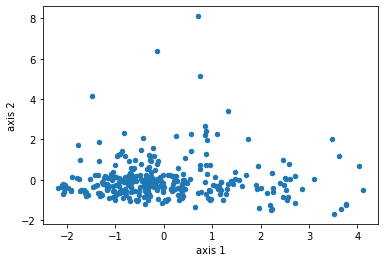

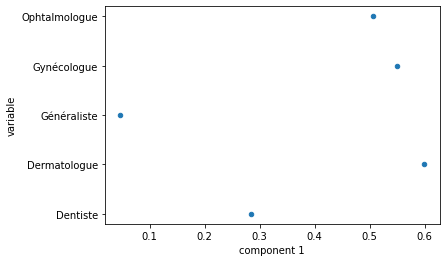

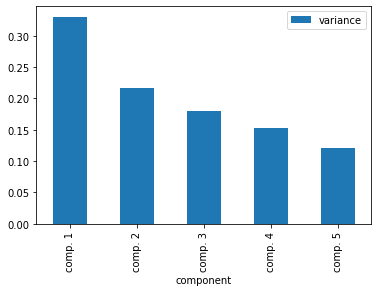

In [78]:
# équivalents avec MatPlotLib
attentes.plot.scatter(x='axis 1', y='axis 2')
components.plot.scatter(x='component 1',y='variable')
components2.plot.bar(x='component', y='variance')

#### Alternatives tolérantes aux valeurs manquantes pour la réduction de dimension

1. Une [discussion sur StackOverFlow](https://stackoverflow.com/questions/29420737/pca-with-missing-values-in-python) suggère d'utiliser une bibliothèque logicielle [peu documentée](https://github.com/el-hult/pyppca).
    ```{python}
    ! pip install git+https://github.com/el-hult/pyppca
    from pyppca import ppca
    C, ss, M, X, Ye = ppca(Y,d,dia)
    ```
2. Une [autre discussion sur CrossValidated](https://stats.stackexchange.com/questions/35561/imputation-of-missing-values-for-pca) pour un problème similaire sur R suggère d'utiliser la fonction `nipals()` de la bibliothèque R `ade4`, qui a été portée sur Python sous le nome de `nipals`. Le package n'est pas très documenté mais la page Github possède un [fichier de test](https://github.com/fredrikw/python-nipals/blob/master/tests/test_nipals.py).
   ```{python}
   ! pip install nipals



Nous avons préféré ne pas nous aventurer sur ces pistes chronophages.

### 3.2 Pas de motif géographique clair dans les temps d'attente


#### On importe les packages nécessaires


In [105]:
# une erreur s'est glissée dans ce code :(
# les données peuvent être téléchargées manuellement
# et dizippées en ligne de commande

# url = 'https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12'
# temporary_location = tempfile.gettempdir()
# location = 'data/sp'

# def download_unzip(
#   url,
#   destname,
#   dirname = tempfile.gettempdir()
# ):
#   myfile = requests.get(url)
#   open("{}/{}.zip".format(dirname, destname), 'wb').write(myfile.content)
#   with zipfile.ZipFile("{}/{}.zip".format(dirname, destname), 'r') as zip_ref:
#       zip_ref.extractall(dirname + '/' + destname)
# 
# download_unzip(url, 'communes', 'data/sp')

#### Importation des coordonnées des communes


In [107]:
#On importe les coordonnées des communes
communes = gpd.read_file("data/sp/communes/communes-20190101.json")
communes = communes.rename(columns={'nom': 'nom_commune'})

#### Jointure des données géopgraphiques et des temps d'attente

In [114]:
temps_att = pd.read_csv("data/2-1-waiting-time-temp.csv")
temps_att = temps_att.rename(columns={'Territoire': 'nom_commune'}) # On modifie le nom de la colomne pour pouvoir merge dessus

communes_att2 = pd.merge(communes, temps_att,on='nom_commune',how='left')


In [118]:
communes_att2

,insee,nom_commune,wikipedia,surf_ha,geometry,Rang sur 314,Dentiste,Dermatologue,Généraliste,Gynécologue,Ophtalmologue,Pédiatre,dep
0,97223,Saint-Esprit,fr:Saint-Esprit (Martinique),2318,"POLYGON ((-60.93595 14.58812, -60.93218 14.585...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
1,97233,Le Morne-Vert,fr:Le Morne-Vert,1325,"POLYGON ((-61.12165 14.71928, -61.11852 14.716...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
2,97208,Fonds-Saint-Denis,fr:Fonds-Saint-Denis,2374,"POLYGON ((-61.13355 14.74657, -61.13066 14.748...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
3,97224,Saint-Joseph,fr:Saint-Joseph (Martinique),4324,"POLYGON ((-61.08459 14.72510, -61.08430 14.722...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
4,97212,Gros-Morne,fr:Gros-Morne,4601,"POLYGON ((-61.08459 14.72510, -61.08061 14.725...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34977,95219,Ermont,fr:Ermont,416,"POLYGON ((2.24366 48.99420, 2.24912 48.99973, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,95
34978,78172,Conflans-Sainte-Honorine,fr:Conflans-Sainte-Honorine,988,"POLYGON ((2.07187 48.99338, 2.07147 48.99554, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,78
34979,78005,Achères,fr:Achères (Yvelines),972,"POLYGON ((2.04907 48.95682, 2.04918 48.96010, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,78
34980,78358,Maisons-Laffitte,fr:Maisons-Laffitte,693,"POLYGON ((2.17312 48.96406, 2.17813 48.96383, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,78


#### Temps moyen d'attente pour un dentiste par département

<AxesSubplot:title={'center':"Temps d'attente pour un rendez-vous chez le dentiste"}>

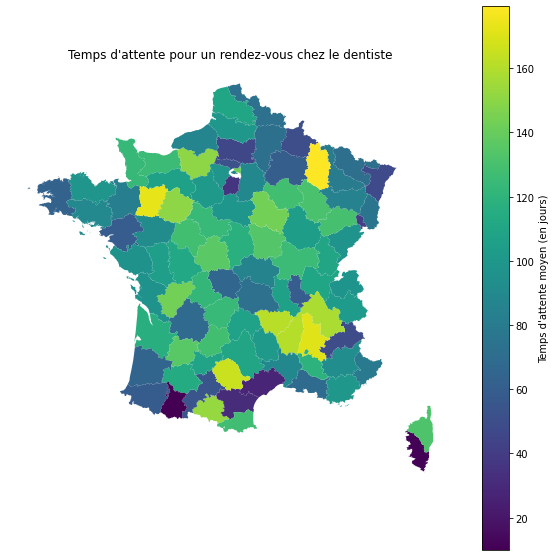

In [116]:
import matplotlib.pyplot as plt
communes_att2['dep'] = communes.insee.str[:2]

fig,ax = plt.subplots(figsize=(10, 10))

communes_att2[communes_att2.dep != "97"].dissolve(by='dep', aggfunc='mean').plot(
    ax = ax,
    column = "Dentiste"
    legend = True,
    legend_kwds = {'label': "Temps d'attente moyen (en jours)"}
)
ax.set_axis_off()
ax.set_title("Temps d'attente pour un rendez-vous chez le dentiste")

ax

#### Temps d'attente moyen (toute spécialités confondues) par département

D'abord on créer un `DataFrame` avec le temps d'attente moyen :

In [123]:
communes_att2['att_moyenne_2'] = communes_att2[
    ['Dentiste', 'Dermatologue','Généraliste','Gynécologue','Ophtalmologue','Pédiatre']
].mean(axis=1)

<AxesSubplot:title={'center':"Temps d'attente moyen pour un rendez-vous chez un médecin"}>

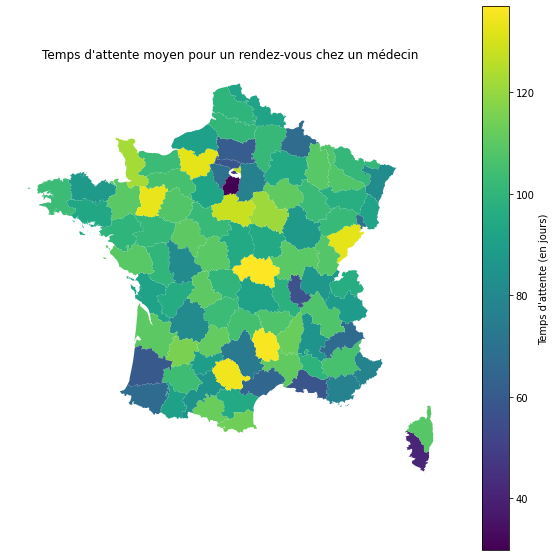

In [126]:
fig,ax = plt.subplots(figsize=(10, 10))

communes_att2[communes_att2.dep != "97"].dissolve(by='dep', aggfunc='mean').plot(
    ax = ax,
    column = "att_moyenne_2",
    legend=True,
    legend_kwds={'label': "Temps d'attente (en jours)"})
ax.set_axis_off()
ax.set_title("Temps d'attente moyen pour un rendez-vous chez un médecin")

ax

#### Observation et conclusion:

Il ne semble pas que le temps d'attente soit réellement déterminé géographiquement. Cependant, les choses suivantes sont à noter. Comme prévu, le bassin parisien est bien desservi. On ne peut pas vraiment noter une fracture nord-sud, cependant les littoraux (sud-est par exemple) semblent disposer de temps d'attente plus faibles que le centre de la France.


## 4. Modélisation

Dans cette section, nous nous restreignons par soucis de simplification à l'analyse du **temps d'attente chez le généraliste**.

### 4.1 RÉGRESSION 


#### Importation des données

In [119]:
import pandas as pd
waiting = pd.read_csv("data/2-6-cancatenated-data.csv")

#### Régression linéaire simple

In [120]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols(
    'GP ~ density + attractiveness_rank',
    data = waiting
).fit()
results.summary()

# plutôt mauvais modèle
# R^2 de 0,35
# Statistiques de Fisher de p-valeur 5%
# (~ 1 chance sur 20 que ce résultat advienne sous hypothèse
# que tous les coefficients soient nuls)

# 13 jours d'attente en moyenne
# 0,0022 jours de plus par hab/m^2 (non significatif)
# 0,0046 jours de plus par rang en moins dans
# le classement des villes où il fait bon vivre

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GP   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     5.034
Date:                Thu, 06 Jan 2022   Prob (F-statistic):            0.00711
Time:                        20:06:45   Log-Likelihood:                -1427.1
No. Observations:                 282   AIC:                             2860.
Df Residuals:                     279   BIC:                             2871.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              13.8075      3.551      3.888      0.000       6.816      20.798
density                 0.0022      0.001      1.851      0.065      -0.000       0.005
attractiveness_rank     0.0046      0.002      3.028      0.003       0.002       0.008
==============================================================================
Omnibus:                      240.818   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3789.672
Skew:                           3.513   Prob(JB):                         0.00
Kurtosis:                      19.527   Cond. No.                     3.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

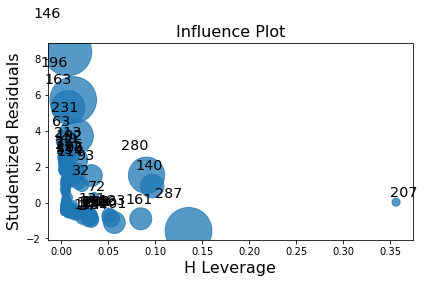

In [121]:
fig = sm.graphics.influence_plot(results, criterion="cooks")
fig.tight_layout(pad=1.0)

# no observation has a tremendous leverage

In [125]:
# par la passé l'agglomération parisienne pesait démusérément dans la régression:
# results = smf.ols(
#    'GP ~ density + attractiveness_rank',
#    data = waiting[ waiting["City"] != "Paris" ]
# ).fit()
# results.summary()

### Régression linéaire généralisée

D'un point de vue modélisation, il n'y a aucune raison que les temps d'attente suivent un loi normale. En effet, d'une part, il n'existe pas de temps d'attente négatif. D'autre part, un temps d'attente a typiquement une distribution asymétrique, avec de nombreux temps d'attente courts, et quelques non négligeables temps d'attente très long. Utiliser un **modèle linéraire généralisé (GLM)** permet en principe de couvrir ce type de cas. Malheurseusement, cette modélisation n'est pas très concluante ici non plus.

In [128]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

dataset = pd.read_csv("data/2-6-cancatenated-data.csv")

results = smf.glm(
    'GP ~ density + attractiveness_rank',
    data=waiting[ waiting["City"] != "Paris" ],
    family=sm.families.Gamma()
).fit()

results.summary()

# pas d'amélioration avec un lien "exponentiel"

/root/venv/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:301: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     GP   No. Observations:                  281
Model:                            GLM   Df Residuals:                      278
Model Family:                   Gamma   Df Model:                            2
Link Function:          inverse_power   Scale:                          3.1782
Method:                          IRLS   Log-Likelihood:                -1226.3
Date:                Thu, 06 Jan 2022   Deviance:                       731.96
Time:                        20:13:22   Pearson chi2:                     884.
No. Iterations:                     9   Pseudo R-squ. (CS):            -0.3385
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0699      0.008      9.040      0.000       0.055       0.085
density              -7.06e-06   1.28e-06     -5.533      0.000   -9.56e-06   -4.56e-06
attractiveness_rank -8.989e-06   1.19e-06     -7.570      0.000   -1.13e-05   -6.66e-06
=======================================================================================
"""

### Récupération des résidus

Les résidus d'une régression peuvent facilement être récupérés avec `results.resid`.

### 4.2 Carte des résidus

Si nous avions pu obtenir un modèle prédicitf, il aurait été intéressant de s'intéresser à la distribution spatiale des **résidus de régressions**. En effet, distinguer une distribution spatial pourrait suggérer des phénomènes spatiaux non compensés par les variables explicatives choisis. L'exercice est un peu artificiel ici puisque la régression précédente est très peu pertinente.

In [130]:
# cette cellule nécessite l'exécution de la cellue contenant la régression au tout début de ce notebook

from math import sqrt
from matplotlib.colors import rgb2hex

# read shapefiles
communes = gpd.read_file("data/sp/communes/communes-20190101.json")
communes = communes.rename(columns={'nom': 'City'})

# bring back variables in the game
waiting_complete_2 = pd.merge(waiting, waiting_complete, how='right')
# merge 
waiting_complete_2 = pd.merge(communes, waiting_complete_2, how='inner', on='City')
# here we lose data from both datasets here, cf. section 7

# collect centroids of shapes
waiting_complete_2['lon'] = waiting_complete_2.geometry.centroid.x
waiting_complete_2['lat'] = waiting_complete_2.geometry.centroid.y

# color maps go from [0,1] to RGB space
# hence we normalise the residuals from 0 to 1
residuals = (waiting_complete_2['resid']-min(waiting_complete_2['resid']))
residuals = residuals/max(residuals)
residuals
# this operation does not necessary maps 0 to 0.5 as expected
# see section 7
colors = plt.cm.bwr(residuals)

# now let's draw the map
m = folium.Map(tiles='Stamen Toner')

# add circles one by one
for i in range(0,len(waiting_complete_2)):
    folium.Circle(
        [waiting_complete_2.iloc[i]['lat'], waiting_complete_2.iloc[i]['lon']],
        radius = 50*sqrt(waiting_complete_2.iloc[i]['population']),
        popup = str(waiting_complete_2.iloc[i]['City'])+"<br> Résidu: "+str(waiting_complete_2.iloc[i]['resid']),
        color = rgb2hex(colors[i]),
        weight = 3,
        fill_color = rgb2hex(colors[i]),
        fill = True,
        fill_opacity = 0.6
    ).add_to(m)

m.fit_bounds([[42.26,-4], [51,8.388]])
m

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



##### Explication de la légende: 
Les cercles de couleur bleu indique que le temps d'attente résiduelle de la commune est négatif. Inversement un cercle rouge indique que celui-ci est positif. Plus la couleur à l'intérieur du cercle est foncée plus on s'éloigne de 0. (ie le bleu foncé indique un temps d'attente résiduel plus négatif que le bleu clair).

##### Observations:
  
Les grandes villes ne semblent avoir des résidus de même signe.
Par exemple:
 **Marseille est sur-dotée en généralistes** (temps d'attente plus courts de 60j par rapport à la moyenne _toutes choses égales par ailleurs_) **alors que Nice est sous-dotée** (temps d'attente plus longs de 124j)

Ici, la dimension spatiale des résidus n'est pas évidente. Étant donnée la fragilité de la régression utilisée en première partie, nous appelons à la précaution avant d'interpréter ces résultats

## 5. Démarche scientifique et reproductibilité

En ce qui concerne notre démarche scientifique, nous sommes partis de'une problématique claire, et avons tenté de justifier nos choix de modélisation, au fur et à mesure qu'ils se présentaient. En particulier nous ne nous cachons pas des limites de notre analyse et proposons quand elles se présentent des pistes d'amélioration (section 7).

La reproductibilité est garantie par la mise à disposition de l'ensmble des données, et de l'ensemble du code.

## 6. Format du code

Le rapport est accessible [sur Deepnote](https://deepnote.com/project/desert-medical-L4EiMo7RTomPSFl-EAWGNw/%2Freport.ipynb), où il est exécutable. La totalité du code et des données sont par ailleurs disponibles [sur Github](https://github.com/katossky/desert-medical). L'historique des enregistrements (_commits_) est disponible [ici](https://github.com/katossky/desert-medical/commits/main). Il n'y a pas eu lieu, vu la simplicité relative du projet, d'avoir recours à des branches de développement.

La plupart du code a été reporté en annexe, mais le rapport contient un exemple filé exécutable pour la ville de Poitiers. Le code est abondamment commenté et nous avons porté un soin particulier au choix des noms de variables afin d'en faciliter la lecture.

## 7. Pistes d'amélioration

- Améliorer la couverture des données par rapport au jeu de données de Marianne. En particulier, il serait possible de renoncer à l'utilisation de variables peu utile dans la modélisation et qui ne couvrent qu'une petite partie de notre échantillon. C'est notamment le cas de la pluviométrie, que nous avons réussi à collecter que dans environ un cas sur deux.

- Étendre la modélisation à l'ensemble des temps d'attentes, séparément dans un premier temps, puis conjointement.

- La visualisation sur la carte considère, un peu grossièrement, le temps d'attente d'un département comme étant égal au temps d'attente moyen de certaines de ses communes. Il pourrait être intéressant d'étudier les différences de temps d'attente à l'intérieur d'un même département. Cependant, l'obtention des données nécessiterait un travail très conséquent. En effet il faudrait reproduire la méthodologie de l'enquête de Marianne mais avec de nouvelles petites communes.

- Au moment de la cartographie des résidus, on perd une grande partie des données: soit parce que les communes ont des variables non renseignées, soit parce que la jointure avec les données géographiques est imparfaite (on utilise pour l'instant le nom de commune). Il vaudrait mieux représenter l'ensemble de toutes les préfectures et sous-préfectures et d'expliciter (par la couleur grise par exemple) que la donnée est manquante.

- La fonction de mise à l'échelle des résidus n'envoie pas nécessairement 0 sur 0,5. C'est un problème car les résidus sont centrés par construction et l'opposition résidu positif vs. négatif a un sens. Nous souhaiterions que le 0 des résidus (i.e. le 0,5 après mise à l'échelle) représente une commune suivant parfaitement la droite de régression, et représenté en blanc sur la carte. Ce n'est pas le cas à cette date.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2f812232-8ed1-4e89-8f48-597e10058637' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>